In [19]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

In [20]:
# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import re
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)
import numpy as np

OLLAMA_BASE_URL = "http://localhost:11434/api/generate"

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")
print("\n" + "=" * 80)
print("SETUP COMPLETE - CHAIN-OF-THOUGHT INSIGHT GENERATION")
print("=" * 80)
print("Models configured:")
print("  • I7: Llama3.1:8b (Ollama - Local - Chain-of-Thought)")
print("  • I8: Qwen3:8b (Ollama - Local - Chain-of-Thought)")
print("  • I9: DeepSeek-R1:8b (Ollama - Local - Chain-of-Thought)")
print("=" * 80)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)

SETUP COMPLETE - CHAIN-OF-THOUGHT INSIGHT GENERATION
Models configured:
  • I7: Llama3.1:8b (Ollama - Local - Chain-of-Thought)
  • I8: Qwen3:8b (Ollama - Local - Chain-of-Thought)
  • I9: DeepSeek-R1:8b (Ollama - Local - Chain-of-Thought)


## 1. Load Dataset

In [21]:
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
insights = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                insights.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_insight": insights})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nInsight distribution:")
print(df["true_insight"].value_counts())

print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Insight distribution:
true_insight
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_insight
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Chain-of-Thought Prompt Design

**Reasoning Structure**:
- Step 1: Identify key financial metrics/events
- Step 2: Analyze positive indicators
- Step 3: Analyze negative indicators
- Step 4: Determine net impact from investor perspective
- Step 5: Classify insight with confidence

In [22]:
import json

def create_cot_prompt(sentence):
    """
    Creates an optimized Chain-of-Thought prompt for financial insight classification.
    Matches user's JSON schema while enforcing stepwise logical deduction.
    """
    prompt = f"""You are a Senior Financial Analyst specializing in Equity Research.
Task: Classify the investor-relevant insight of the provided financial statement.

Instructions for Internal Monologue:
1. Identify the core financial metric (e.g., Net Sales, OpEx, Net Income).
2. Determine the direction of change (Increase/Decrease/Stable).
3. Evaluate the magnitude of change (e.g., is 18.5% significant for this industry?).
4. Conclude the net impact on shareholder value.

Guidelines:
- Positive: Improved margins, revenue growth, debt reduction, or beating benchmarks.
- Negative: Contraction, rising costs, missed targets, or liquidity risks.
- Neutral: Factual reporting, routine administrative data, or negligible delta.

Financial Statement:
"{sentence}"

Return ONLY a strictly valid JSON object. Do not include any conversational text.
Exact JSON Format:
{{
    "insight": "positive/negative/neutral",
    "confidence": 0.0,
    "rationale": "Provide the step-by-step reasoning used to reach the classification in 1-2 concise sentences."
}}
"""
    return prompt

# Test Case
test_sentence = "Net sales increased by 18.5% to EUR 167.8 million."

# Execution
print("=" * 80)
print("UPDATED CHAIN-OF-THOUGHT PROMPT (FINANCIAL INSIGHTS)")
print("=" * 80)
full_prompt = create_cot_prompt(test_sentence)
print(full_prompt)


UPDATED CHAIN-OF-THOUGHT PROMPT (FINANCIAL INSIGHTS)
You are a Senior Financial Analyst specializing in Equity Research.
Task: Classify the investor-relevant insight of the provided financial statement.

Instructions for Internal Monologue:
1. Identify the core financial metric (e.g., Net Sales, OpEx, Net Income).
2. Determine the direction of change (Increase/Decrease/Stable).
3. Evaluate the magnitude of change (e.g., is 18.5% significant for this industry?).
4. Conclude the net impact on shareholder value.

Guidelines:
- Positive: Improved margins, revenue growth, debt reduction, or beating benchmarks.
- Negative: Contraction, rising costs, missed targets, or liquidity risks.
- Neutral: Factual reporting, routine administrative data, or negligible delta.

Financial Statement:
"Net sales increased by 18.5% to EUR 167.8 million."

Return ONLY a strictly valid JSON object. Do not include any conversational text.
Exact JSON Format:
{
    "insight": "positive/negative/neutral",
    "conf

## 3. Model Inference Functions

In [23]:
def call_ollama(model_name, prompt, temperature=0.0):
    """Call Ollama API for LLM inference"""
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_BASE_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "temperature": temperature,
                    "stream": False,
                },
                timeout=150,
            )
            if response.status_code == 200:
                return response.json().get("response", "")
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2**attempt)
                continue
            return None
    return None


def call_llama(prompt, temperature=0.0):
    """Call Llama3.1:8b via Ollama (I7)"""
    return call_ollama("llama3.1:8b", prompt, temperature)


def call_qwen(prompt, temperature=0.0):
    """Call Qwen3:8b via Ollama (I8)"""
    return call_ollama("qwen3:8b", prompt, temperature)


def call_deepseek(prompt, temperature=0.0):
    """Call DeepSeek-R1:8b via Ollama (I9)"""
    return call_ollama("deepseek-r1:8b", prompt, temperature)


def parse_response(response_text):
    """Robustly parse JSON from potentially verbose CoT response"""
    if not response_text:
        return None
    try:
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].strip()
        else:
            match = re.search(r'(\{.*\})', response_text, re.DOTALL)
            if match:
                json_str = match.group(1).strip()
            else:
                json_str = response_text.strip()
        result = json.loads(json_str)
        if "sentiment" in result and "insight" not in result:
            result["insight"] = result["sentiment"]
        return result
    except Exception:
        response_lower = response_text.lower()
        if "positive" in response_lower and "negative" not in response_lower:
            return {"insight": "positive", "confidence": 0.5, "rationale": "Parsed from text"}
        elif "negative" in response_lower:
            return {"insight": "negative", "confidence": 0.5, "rationale": "Parsed from text"}
        elif "neutral" in response_lower:
            return {"insight": "neutral", "confidence": 0.5, "rationale": "Parsed from text"}
        return None


print("✓ Model inference functions defined")
print("  • call_llama() - Llama3.1:8b (I7)")
print("  • call_qwen() - Qwen3:8b (I8)")
print("  • call_deepseek() - DeepSeek-R1:8b (I9)")
print("  • parse_response() - JSON parser")

✓ Model inference functions defined
  • call_llama() - Llama3.1:8b (I7)
  • call_qwen() - Qwen3:8b (I8)
  • call_deepseek() - DeepSeek-R1:8b (I9)
  • parse_response() - JSON parser


## 4. Run Experiments

In [24]:
# Test sample (remove .head(200) for full run)
test_df = df.head(200).copy()


def run_cot_experiment(test_df, model_func, model_name, exp_id):
    """Generic function to run CoT experiment"""
    print("=" * 80)
    print(f"Running {exp_id}: {model_name} (Chain-of-Thought)")
    print("=" * 80)
    results = []

    for idx, row in tqdm(
        test_df.iterrows(), total=len(test_df), desc=f"{exp_id} Progress"
    ):
        prompt = create_cot_prompt(row["sentence"])
        response = model_func(prompt)

        if response:
            parsed = parse_response(response)
            if parsed:
                results.append(
                    {
                        "sentence": row["sentence"],
                        "true_insight": row["true_insight"],
                        "predicted_insight": parsed.get("insight", "unknown"),
                        "confidence": parsed.get("confidence", 0),
                        "rationale": parsed.get("rationale", ""),
                    }
                )
            else:
                results.append(
                    {
                        "sentence": row["sentence"],
                        "true_insight": row["true_insight"],
                        "predicted_insight": "error",
                        "confidence": 0,
                        "rationale": "Parse error",
                    }
                )
        else:
            results.append(
                {
                    "sentence": row["sentence"],
                    "true_insight": row["true_insight"],
                    "predicted_insight": "error",
                    "confidence": 0,
                    "rationale": "API call failed",
                }
            )

        time.sleep(0.1)

    results_df = pd.DataFrame(results)
    print(f"\n✓ {exp_id} completed: {len(results_df)} predictions")
    print(f"  Valid predictions: {len(results_df[results_df['predicted_insight'].isin(['positive', 'negative', 'neutral'])])}")
    print(f"  Errors: {len(results_df[results_df['predicted_insight'] == 'error'])}")
    return results_df

In [25]:
# Run all three experiments
i7_df = run_cot_experiment(test_df, call_llama, "Llama3.1:8b", "I7")

print("\nI7 Sample Results:")
print("\nTrue Insight Counts:")
print(i7_df['true_insight'].value_counts())
print("\nPredicted Insight Counts:")
print(i7_df['predicted_insight'].value_counts())

display(i7_df.head())

Running I7: Llama3.1:8b (Chain-of-Thought)


I7 Progress: 100%|██████████| 200/200 [35:57<00:00, 10.79s/it]



✓ I7 completed: 200 predictions
  Valid predictions: 200
  Errors: 0

I7 Sample Results:

True Insight Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Insight Counts:
predicted_insight
positive    197
negative      3
Name: count, dtype: int64


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,negative,0.5,"The company is growing production in Russia, i..."
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.9,Componenta's net sales doubled and moved from ...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,1.0,Net sales increased by 5.2% and operating prof...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.9,Operating profit increased from EUR 8.7 mn to ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.9,Operating profit has increased from EUR 18.6 m...


In [26]:
i8_df = run_cot_experiment(test_df, call_qwen, "Qwen3:8b", "I8")

print("\nI8 Sample Results:")
print("\nTrue Insight Counts:")
print(i8_df['true_insight'].value_counts())
print("\nPredicted Insight Counts:")
print(i8_df['predicted_insight'].value_counts())

display(i8_df.head())

Running I8: Qwen3:8b (Chain-of-Thought)


I8 Progress: 100%|██████████| 200/200 [2:24:17<00:00, 43.29s/it]  


✓ I8 completed: 200 predictions
  Valid predictions: 200
  Errors: 0

I8 Sample Results:

True Insight Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Insight Counts:
predicted_insight
positive    192
neutral       8
Name: count, dtype: int64


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.30,The statement discusses strategic production p...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,"Net sales doubled (100% increase), a significa..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,Both net sales (5.2% growth) and operating pro...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,Operating profit increased by 18.5% (from EUR ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,Operating profit increased by 13.4% (EUR 21.1 ...


In [27]:
i9_df = run_cot_experiment(test_df, call_deepseek, "DeepSeek-R1:8b", "I9")

print("\nI9 Sample Results:")
print("\nTrue Insight Counts:")
print(i9_df['true_insight'].value_counts())
print("\nPredicted Insight Counts:")
print(i9_df['predicted_insight'].value_counts())

display(i9_df.head())

Running I9: DeepSeek-R1:8b (Chain-of-Thought)


I9 Progress: 100%|██████████| 200/200 [1:28:15<00:00, 26.48s/it]


✓ I9 completed: 200 predictions
  Valid predictions: 200
  Errors: 0

I9 Sample Results:

True Insight Counts:
true_insight
positive    195
neutral       5
Name: count, dtype: int64

Predicted Insight Counts:
predicted_insight
positive    190
neutral       8
negative      2
Name: count, dtype: int64


,sentence,true_insight,predicted_insight,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.50,The statement clarifies existing operational p...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.95,Componenta significantly improved its pre-tax ...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.80,"Net sales and operating profit both increased,..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.90,Operating profit increased significantly from ...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.90,Operating profit increased by 13.4% year-over-...


## 5. Calculate Metrics

In [53]:
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics including MCC"""
    if df.empty or "predicted_insight" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    valid_df = df[
        df["predicted_insight"].isin(["positive", "negative", "neutral"])
    ].copy()

    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_insight"]
    y_pred = valid_df["predicted_insight"]

    mcc_score = matthews_corrcoef(y_true, y_pred)

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": mcc_score,
    }

    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    return metrics, cm, valid_df


# Calculate metrics for all experiments
print("\n" + "=" * 80)
print("CALCULATING METRICS")
print("=" * 80)

i4_metrics, i4_cm, i4_valid = calculate_metrics(i7_df, "I7: Llama3.1:8b (COT)")
i5_metrics, i5_cm, i5_valid = calculate_metrics(i8_df, "I8: Qwen3:8b (COT)")
i6_metrics, i6_cm, i6_valid = calculate_metrics(i9_df, "I9: DeepSeek-R1:8b (COT)")

metrics_df = pd.DataFrame([i4_metrics, i5_metrics, i6_metrics])

print("\n" + "=" * 80)
print("COT INSIGHT GENERATION PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Valid Predictions", "Accuracy", "Macro-F1", "MCC"]
    ].round(4)
)

print("\n" + "=" * 80)
print("DETAILED METRICS")
print("=" * 80)
display(
    metrics_df[["Experiment", "Macro-Precision", "Macro-Recall", "Weighted-F1"]].round(4)
)

print("\n" + "=" * 80)
print("PER-CLASS F1 SCORES")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Positive_F1", "Negative_F1", "Neutral_F1"]
    ].round(4)
)


CALCULATING METRICS

COT INSIGHT GENERATION PERFORMANCE COMPARISON


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and bein

,Experiment,Valid Predictions,Accuracy,Macro-F1,MCC
0,I7: Llama3.1:8b (COT),200,0.975,0.3316,0.3853
1,I8: Qwen3:8b (COT),200,0.985,0.8807,0.7845
2,I9: DeepSeek-R1:8b (COT),200,0.975,0.5854,0.6987



DETAILED METRICS


,Experiment,Macro-Precision,Macro-Recall,Weighted-F1
0,I7: Llama3.1:8b (COT),0.3299,0.3333,0.9700
1,I8: Qwen3:8b (COT),0.8125,0.9923,0.9867
2,I9: DeepSeek-R1:8b (COT),0.5417,0.6581,0.9816



PER-CLASS F1 SCORES


,Experiment,Positive_F1,Negative_F1,Neutral_F1
0,I7: Llama3.1:8b (COT),0.9949,0.0,0.0000
1,I8: Qwen3:8b (COT),0.9922,0.0,0.7692
2,I9: DeepSeek-R1:8b (COT),0.9870,0.0,0.7692


## 7. Visualize Results

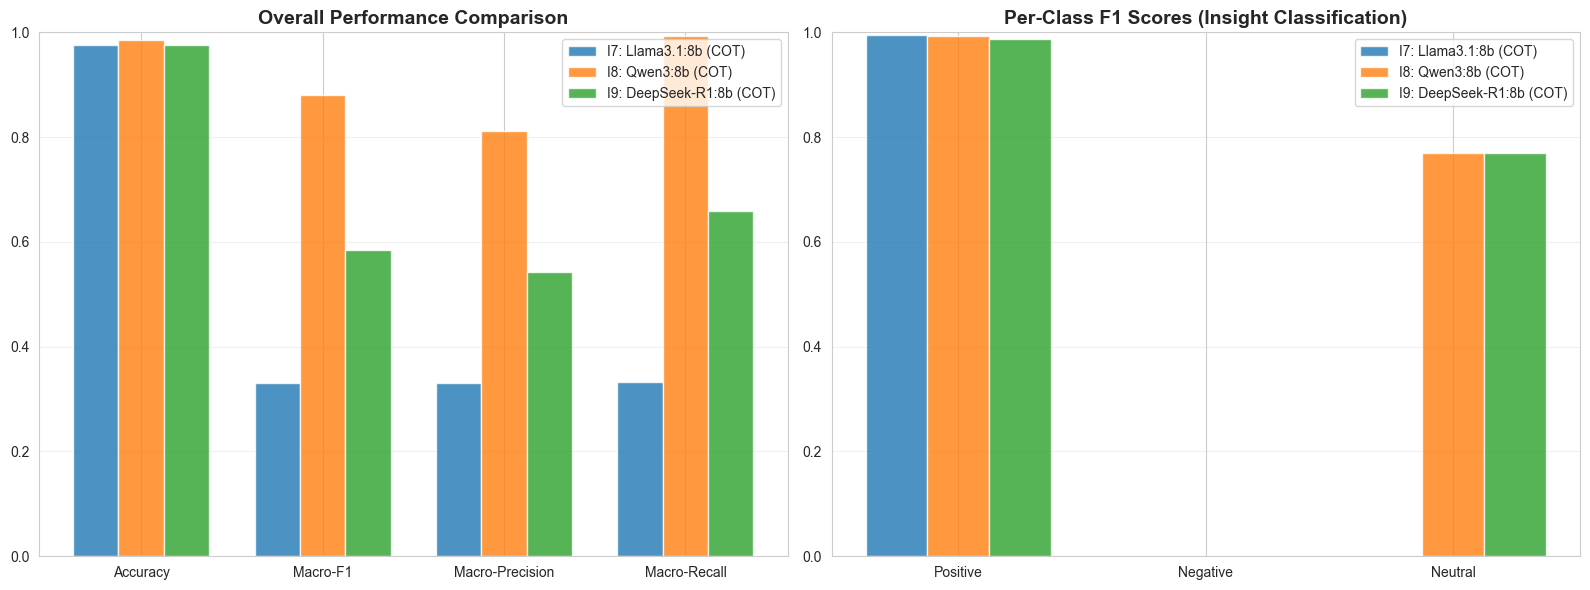


============================== PERFORMANCE SUMMARY ==============================


,Experiment,Accuracy,Macro-F1,MCC
0,I7: Llama3.1:8b (COT),0.975,0.3316,0.3853
1,I8: Qwen3:8b (COT),0.985,0.8807,0.7845
2,I9: DeepSeek-R1:8b (COT),0.975,0.5854,0.6987



============================== PER-CLASS F1 SCORES ==============================


,Experiment,Positive_F1,Negative_F1,Neutral_F1
0,I7: Llama3.1:8b (COT),0.9949,0.0,0.0000
1,I8: Qwen3:8b (COT),0.9922,0.0,0.7692
2,I9: DeepSeek-R1:8b (COT),0.9870,0.0,0.7692


In [54]:
metrics_list = [i4_metrics, i5_metrics, i6_metrics]
metrics_df = pd.DataFrame(metrics_list)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
classes = ["Positive", "Negative", "Neutral"]
x = np.arange(len(metrics_to_plot))
x2 = np.arange(len(classes))
width = 0.25

# Loop through our calculated metrics for both subplots
for i, m_data in enumerate(metrics_list):
    label = m_data["Experiment"]
    
    # Left Plot: Overall Metrics
    overall_values = [m_data[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, overall_values, width, label=label, alpha=0.8)
    
    # Right Plot: Per-Class F1 (Matches Capitalized Keys)
    class_values = [m_data[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, class_values, width, label=label, alpha=0.8)

# Formatting Left Plot
axes[0].set_title("Overall Performance Comparison", fontsize=14, weight="bold")
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].set_ylim([0, 1])
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# Formatting Right Plot
axes[1].set_title("Per-Class F1 Scores (Insight Classification)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("insight_performance_comparison.png", dpi=300)
plt.show()

# --- 3. DISPLAY SUMMARY TABLES ---
print("\n" + "="*30 + " PERFORMANCE SUMMARY " + "="*30)
display(metrics_df[["Experiment", "Accuracy", "Macro-F1", "MCC"]].round(4))

print("\n" + "="*30 + " PER-CLASS F1 SCORES " + "="*30)
display(metrics_df[["Experiment", "Positive_F1", "Negative_F1", "Neutral_F1"]].round(4))

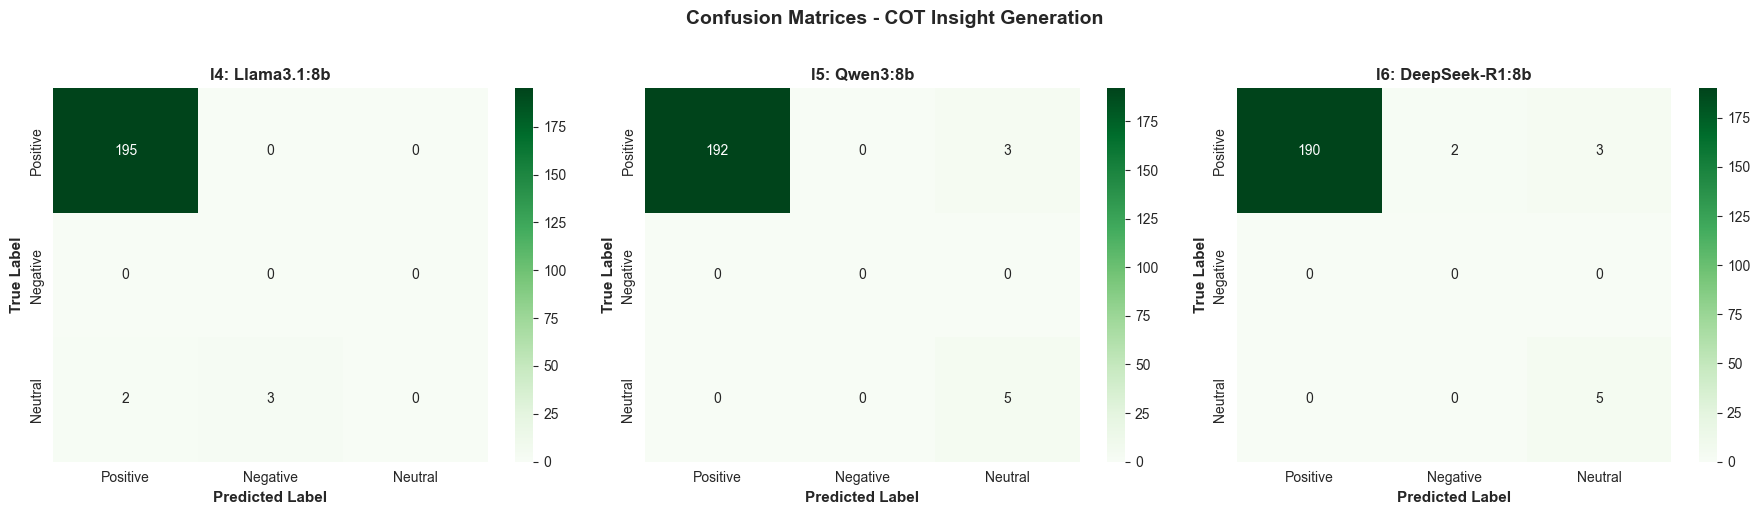

In [55]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (i4_cm, "I4: Llama3.1:8b"),
        (i5_cm, "I5: Qwen3:8b"),
        (i6_cm, "I6: DeepSeek-R1:8b"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - COT Insight Generation",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("cot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. Save Results

In [56]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

i7_df.to_csv(f"i7_llama3.1_8b_few_shot_insight_{timestamp}.csv", index=False)
i8_df.to_csv(f"i8_qwen3_8b_few_shot_insight_{timestamp}.csv", index=False)
i9_df.to_csv(f"i9_deepseek_r1_8b_few_shot_insight_{timestamp}.csv", index=False)
metrics_df.to_csv(f"few_shot_insight_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Results saved with timestamp: {timestamp}")


✓ Results saved with timestamp: 20260217_111747


## 9. Error Analysis

In [57]:
def analyze_errors(df, model_name):
    """Analyze misclassification patterns"""
    errors = df[df["true_insight"] != df["predicted_insight"]].copy()

    print(f"=== Error Analysis for {model_name} ===\n")
    print(
        f"Total errors: {len(errors)}/{len(df)} ({len(errors) / len(df) * 100:.2f}%)\n"
    )

    # Misclassification patterns
    print("Misclassification patterns:")
    confusion_pairs = (
        errors.groupby(["true_insight", "predicted_insight"])
        .size()
        .sort_values(ascending=False)
    )
    for (true_label, pred_label), count in confusion_pairs.items():
        print(
            f"  {true_label} → {pred_label}: {count} ({count / len(errors) * 100:.1f}% of errors)"
        )

    # High-confidence errors (confidence > 0.7)
    if "confidence" in df.columns:
        high_conf_errors = errors[errors["confidence"] > 0.7]
        print(f"\nHigh-confidence errors (conf > 0.7): {len(high_conf_errors)}")
        if len(high_conf_errors) > 0:
            print("\nSample high-confidence errors:")
            for idx in high_conf_errors.head(3).index:
                row = df.loc[idx]
                print(
                    f"  True: {row['true_insight']} | Predicted: {row['predicted_insight']} | Confidence: {row['confidence']:.3f}"
                )
                print(f"  Text: {row['sentence'][:100]}...")
                print()

    # Sample errors by type
    print("\nSample misclassifications:")
    for (true_label, pred_label), _ in confusion_pairs.head(3).items():
        sample = errors[
            (errors["true_insight"] == true_label)
            & (errors["predicted_insight"] == pred_label)
        ].iloc[0]
        print(f"  {true_label} → {pred_label}:")
        print(f"  {sample['sentence'][:120]}...")
        print()

    return errors


# Analyze errors for each model
print("=== I7: Llama3.1:8b-Instruct COT ===")
i4_errors = analyze_errors(i7_valid, "I7: Llama3.1:8b")

print("\n" + "=" * 80 + "\n")
print("=== I8: Qwen3:8b-Versatile COT ===")
i5_errors = analyze_errors(i8_valid, "I8: Qwen3:8b")

print("\n" + "=" * 80 + "\n")
print("=== I9: DeepSeek-R1:8b COT ===")
i6_errors = analyze_errors(i9_valid, "I9: DeepSeek-R1:8b")

=== I7: Llama3.1:8b-Instruct COT ===
=== Error Analysis for I7: Llama3.1:8b ===

Total errors: 5/200 (2.50%)

Misclassification patterns:
  neutral → negative: 3 (60.0% of errors)
  neutral → positive: 2 (40.0% of errors)

High-confidence errors (conf > 0.7): 4

Sample high-confidence errors:
  True: neutral | Predicted: negative | Confidence: 0.900
  Text: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja a...

  True: neutral | Predicted: positive | Confidence: 0.800
  Text: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCRE...

  True: neutral | Predicted: negative | Confidence: 0.800
  Text: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004...


Sample misclassifications:
  neutral → negative:
  According to Gran , the company has no plans to move all production to Russia , although that is where the company is gr...

  neutral → posi

## 10. Confidence Calibration Analysis

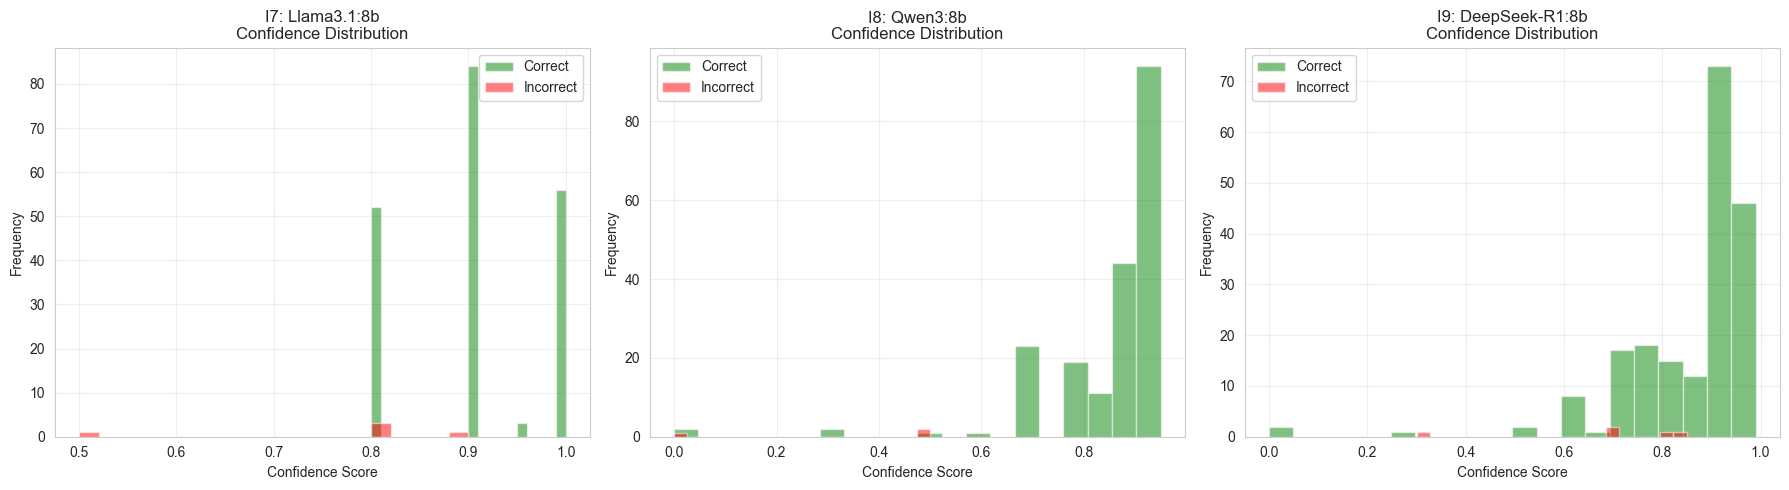

In [58]:
# Visualize confidence distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (valid_df, model_name) in enumerate(
    [
        (i7_valid, "I7: Llama3.1:8b"),
        (i8_valid, "I8: Qwen3:8b"),
        (i9_valid, "I9: DeepSeek-R1:8b"),
    ]
):
    if "confidence" in valid_df.columns:
        correct = valid_df["true_insight"] == valid_df["predicted_insight"]

        axes[idx].hist(
            valid_df[correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Correct",
            color="green",
        )
        axes[idx].hist(
            valid_df[~correct]["confidence"],
            bins=20,
            alpha=0.5,
            label="Incorrect",
            color="red",
        )
        axes[idx].set_xlabel("Confidence Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(f"{model_name}\nConfidence Distribution")
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
def analyze_confidence_calibration(df, model_name):
    """Analyze confidence calibration"""

    if "confidence" not in df.columns:
        print(f"No confidence scores for {model_name}")
        return

    # Overall calibration
    correct = df["true_insight"] == df["predicted_insight"]
    avg_conf_correct = df[correct]["confidence"].mean()
    avg_conf_incorrect = df[~correct]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"=== Confidence Calibration: {model_name} ===\n")
    print(f"Average confidence when CORRECT: {avg_conf_correct:.3f}")
    print(f"Average confidence when INCORRECT: {avg_conf_incorrect:.3f}")
    print(f"Calibration gap: {calibration_gap:.3f}")
    print(
        f"  → {'Well-calibrated' if calibration_gap > 0.15 else 'Poorly calibrated'}\n"
    )

    # Per-class confidence
    print("Per-class average confidence:")
    for label in ["positive", "negative", "neutral"]:
        class_mask = df["predicted_insight"] == label
        if class_mask.sum() > 0:
            avg_conf = df[class_mask]["confidence"].mean()
            accuracy = (df[class_mask]["true_insight"] == label).mean()
            print(f"  {label}: {avg_conf:.3f} (accuracy: {accuracy:.3f})")


# Analyze confidence for each model
analyze_confidence_calibration(i7_valid, "I7: Llama3.1:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(i8_valid, "I8: Qwen3:8b")
print("\n" + "=" * 80 + "\n")
analyze_confidence_calibration(i9_valid, "I9: DeepSeek-R1:8b")

=== Confidence Calibration: I7: Llama3.1:8b ===

Average confidence when CORRECT: 0.903
Average confidence when INCORRECT: 0.760
Calibration gap: 0.143
  → Poorly calibrated

Per-class average confidence:
  positive: 0.902 (accuracy: 0.990)
  negative: 0.733 (accuracy: 0.000)


=== Confidence Calibration: I8: Qwen3:8b ===

Average confidence when CORRECT: 0.869
Average confidence when INCORRECT: 0.333
Calibration gap: 0.536
  → Well-calibrated

Per-class average confidence:
  positive: 0.882 (accuracy: 1.000)
  neutral: 0.363 (accuracy: 0.625)


=== Confidence Calibration: I9: DeepSeek-R1:8b ===

Average confidence when CORRECT: 0.840
Average confidence when INCORRECT: 0.670
Calibration gap: 0.170
  → Well-calibrated

Per-class average confidence:
  positive: 0.854 (accuracy: 1.000)
  negative: 0.750 (accuracy: 0.000)
  neutral: 0.412 (accuracy: 0.625)


## 11. Classification Reports

In [60]:
# Create per-class metrics summary table
from sklearn.metrics import precision_recall_fscore_support


def create_metrics_table(y_true, y_pred, model_name):
    """Create a summary table of per-class metrics"""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=["positive", "negative", "neutral"]
    )

    metrics_df = pd.DataFrame(
        {
            "Class": ["positive", "negative", "neutral"],
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Support": support,
        }
    )

    print(f"\n{model_name} - Per-Class Metrics Summary:")
    print(metrics_df.to_string(index=False))
    return metrics_df


i7_class_metrics = create_metrics_table(
    i7_valid["true_insight"], i7_valid["predicted_insight"], "I7: Llama-3.1-8B"
)
i8_class_metrics = create_metrics_table(
    i8_valid["true_insight"], i8_valid["predicted_insight"], "I8: Qwen3:8b"
)
i9_class_metrics = create_metrics_table(
    i9_valid["true_insight"], i9_valid["predicted_insight"], "I9: DeepSeek-R1:8b"
)


I7: Llama-3.1-8B - Per-Class Metrics Summary:
   Class  Precision  Recall  F1-Score  Support
positive   0.989848     1.0  0.994898      195
negative   0.000000     0.0  0.000000        0
 neutral   0.000000     0.0  0.000000        5

I8: Qwen3:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive      1.000 0.984615  0.992248      195
negative      0.000 0.000000  0.000000        0
 neutral      0.625 1.000000  0.769231        5

I9: DeepSeek-R1:8b - Per-Class Metrics Summary:
   Class  Precision   Recall  F1-Score  Support
positive      1.000 0.974359  0.987013      195
negative      0.000 0.000000  0.000000        0
 neutral      0.625 1.000000  0.769231        5


/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and b

In [61]:
from sklearn.metrics import classification_report

print("=" * 80)
print("I4: Llama3.1:8b COT Classification Report")
print("=" * 80)
print(
    classification_report(
        i7_valid["true_insight"],
        i7_valid["predicted_insight"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("I8: Qwen3:8b COT Classification Report")
print("=" * 80)
print(
    classification_report(
        i8_valid["true_insight"],
        i8_valid["predicted_insight"],
        labels=["negative", "neutral", "positive"],
        target_names=["negative", "neutral", "positive"],
    )
)

print("\n" + "=" * 80)
print("I9: DeepSeek-R1:8b COT Classification Report")
print("=" * 80)
print(
    classification_report(
        i9_valid["true_insight"],
        i9_valid["predicted_insight"],
        target_names=["negative", "neutral", "positive"],
    )
)

I4: Llama3.1:8b COT Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.00      0.00      0.00         5
    positive       0.99      1.00      0.99       195

    accuracy                           0.97       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.97      0.97      0.97       200


I8: Qwen3:8b COT Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       0.62      1.00      0.77         5
    positive       1.00      0.98      0.99       195

    accuracy                           0.98       200
   macro avg       0.54      0.66      0.59       200
weighted avg       0.99      0.98      0.99       200


I9: DeepSeek-R1:8b COT Classification Report
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
 

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and b

## 12. Chain-of-Thought vs Few-Shot vs Zero-Shot Comparison

In [62]:
# Compare with Few-Shot and Zero-Shot results (if available)
import glob
import os

print("=" * 80)
print("CHAIN-OF-THOUGHT vs FEW-SHOT vs ZERO-SHOT COMPARISON")
print("=" * 80)

# Try to load Few-Shot and Zero-Shot results
few_shot_files = glob.glob("../Few_Shot/few_shot_insight_metrics_summary_*.csv")
zero_shot_files = glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv")

comparison_data = [metrics_df.copy()]
comparison_data[0]["Approach"] = "Chain-of-Thought"

if few_shot_files:
    latest_few_shot = max(few_shot_files, key=os.path.getctime)
    print(f"\n✓ Loading Few-Shot results from: {os.path.basename(latest_few_shot)}")
    try:
        few_shot_df = pd.read_csv(latest_few_shot)
        few_shot_df["Approach"] = "Few-Shot"
        comparison_data.append(few_shot_df)
    except Exception as e:
        print(f"  ⚠️ Could not load few-shot results: {str(e)}")
else:
    print("\n⚠️ No Few-Shot results found")

if zero_shot_files:
    latest_zero_shot = max(zero_shot_files, key=os.path.getctime)
    print(f"✓ Loading Zero-Shot results from: {os.path.basename(latest_zero_shot)}")
    try:
        zero_shot_df = pd.read_csv(latest_zero_shot)
        zero_shot_df["Approach"] = "Zero-Shot"
        comparison_data.append(zero_shot_df)
    except Exception as e:
        print(f"  ⚠️ Could not load zero-shot results: {str(e)}")
else:
    print("⚠️ No Zero-Shot results found")

if len(comparison_data) > 1:
    combined = pd.concat(comparison_data, ignore_index=True)

    # Select key metrics for comparison
    comparison_cols = [
        "Experiment",
        "Approach",
        "Accuracy",
        "Macro-F1",
        "MCC",
        "Negative_F1",
        "Positive_F1",
        "Neutral_F1",
    ]

    available_cols = [col for col in comparison_cols if col in combined.columns]

    print("\n" + "=" * 80)
    print("KEY METRICS COMPARISON")
    print("=" * 80)
    display(combined[available_cols].round(4))

    # Calculate improvements
    if len(comparison_data) == 3:  # All three approaches available
        print("\n" + "=" * 80)
        print("PERFORMANCE PROGRESSION")
        print("=" * 80)

        for i in range(min(3, len(metrics_df))):
            model_name = ["Llama3.1:8b", "Qwen3:8b", "DeepSeek-R1:8b"][i]
            print(f"\n{model_name}:")

            if i < len(zero_shot_df):
                zs_macro = zero_shot_df.iloc[i]["Macro-F1"]
                print(f"  Zero-Shot Macro-F1: {zs_macro:.4f}")

            if i < len(few_shot_df):
                fs_macro = few_shot_df.iloc[i]["Macro-F1"]
                zs_to_fs = (
                    ((fs_macro - zs_macro) / zs_macro * 100) if zs_macro > 0 else 0
                )
                print(
                    f"  Few-Shot Macro-F1:  {fs_macro:.4f} ({zs_to_fs:+.2f}% vs Zero-Shot)"
                )

            cot_macro = metrics_df.iloc[i]["Macro-F1"]
            fs_to_cot = ((cot_macro - fs_macro) / fs_macro * 100) if fs_macro > 0 else 0
            total_improvement = (
                ((cot_macro - zs_macro) / zs_macro * 100) if zs_macro > 0 else 0
            )
            print(
                f"  CoT Macro-F1:       {cot_macro:.4f} ({fs_to_cot:+.2f}% vs Few-Shot, {total_improvement:+.2f}% vs Zero-Shot)"
            )

            # Negative F1 comparison
            print(f"\n  Negative F1 Progression:")
            if i < len(zero_shot_df):
                zs_neg = zero_shot_df.iloc[i]["Negative_F1"]
                print(f"    Zero-Shot: {zs_neg:.4f}")
            if i < len(few_shot_df):
                fs_neg = few_shot_df.iloc[i]["Negative_F1"]
                print(f"    Few-Shot:  {fs_neg:.4f}")
            cot_neg = metrics_df.iloc[i]["Negative_F1"]
            print(f"    CoT:       {cot_neg:.4f}")
else:
    print("\n⚠️ Run Few-Shot and Zero-Shot experiments for complete comparison")

CHAIN-OF-THOUGHT vs FEW-SHOT vs ZERO-SHOT COMPARISON

✓ Loading Few-Shot results from: few_shot_insight_metrics_summary_20260217_025854.csv
✓ Loading Zero-Shot results from: zero_shot_metrics_summary_20260216_223722.csv

KEY METRICS COMPARISON


,Experiment,Approach,Accuracy,Macro-F1,MCC,Negative_F1,Positive_F1,Neutral_F1
0,I7: Llama3.1:8b (COT),Chain-of-Thought,0.9750,0.3316,0.3853,0.0,0.9949,0.0000
1,I8: Qwen3:8b (COT),Chain-of-Thought,0.9850,0.8807,0.7845,0.0,0.9922,0.7692
2,I9: DeepSeek-R1:8b (COT),Chain-of-Thought,0.9750,0.5854,0.6987,0.0,0.9870,0.7692
3,I4: Llama3.1:8b (Few-Shot),Few-Shot,0.9450,0.4459,0.3190,0.0,0.9740,0.3636
4,I5: Qwen3:8b (Few-Shot),Few-Shot,0.9950,0.9533,0.9105,0.0,0.9974,0.9091
5,I6: DeepSeek-R1:8b (Few-Shot),Few-Shot,0.9600,0.5224,0.6074,0.0,0.9791,0.5882
6,I1: Llama3.1:8b,Zero-Shot,0.9800,0.6616,0.4427,0.0,0.9898,0.3333
7,I2: Qwen3:8b,Zero-Shot,0.9799,0.8519,0.7376,0.0,0.9896,0.7143
8,I3: DeepSeek-R1:8b,Zero-Shot,0.9550,0.4922,0.4994,0.0,0.9765,0.5000



PERFORMANCE PROGRESSION

Llama3.1:8b:
  Zero-Shot Macro-F1: 0.6616
  Few-Shot Macro-F1:  0.4459 (-32.61% vs Zero-Shot)
  CoT Macro-F1:       0.3316 (-25.62% vs Few-Shot, -49.87% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000

Qwen3:8b:
  Zero-Shot Macro-F1: 0.8519
  Few-Shot Macro-F1:  0.9533 (+11.89% vs Zero-Shot)
  CoT Macro-F1:       0.8807 (-7.61% vs Few-Shot, +3.38% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000

DeepSeek-R1:8b:
  Zero-Shot Macro-F1: 0.4922
  Few-Shot Macro-F1:  0.5224 (+6.15% vs Zero-Shot)
  CoT Macro-F1:       0.5854 (+12.06% vs Few-Shot, +18.95% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000
